# **1. CGRTool**

In [21]:
import sys
from pathlib import Path
sys.path.append('../../')
from SynTemp.SynUtils.utils import load_database
import pandas as pd


cgrtool = pd.read_csv('../..//Data/AAM/cgrtool_benchmark/golden_cgrtool_check.csv', index_col=0)
aam_valid = pd.DataFrame(load_database('../../Data/AAM/unbalance/golden/golden_aam_reactions.json.gz'))

In [22]:
from SynTemp.SynAAM.aam_validator import AMMValidator
aam_valid_results, _ = AMMValidator.validate_smiles(
        data=aam_valid,
        ground_truth_col="ground_truth",
        mapped_cols=["rxn_mapper", "graphormer", "local_mapper"],
        check_method="RC",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=0,
        ensemble=False,
        strategies=[["rxn_mapper", "graphormer", "local_mapper"]],
        ignore_tautomers=False
    )
aam_valid_results = pd.DataFrame(aam_valid_results)
display(aam_valid_results)

[16:12:17] Can't kekulize mol.  Unkekulized atoms: 2 6
[16:12:18] Tautomer enumeration stopped at 288 tautomers: max transforms reached
[16:12:18] Tautomer enumeration stopped at 577 tautomers: max transforms reached
[16:12:19] Tautomer enumeration stopped at 414 tautomers: max transforms reached
[16:12:19] Tautomer enumeration stopped at 424 tautomers: max transforms reached
[16:12:20] Can't kekulize mol.  Unkekulized atoms: 2 6
[16:12:20] Can't kekulize mol.  Unkekulized atoms: 2 6
[16:12:20] Can't kekulize mol.  Unkekulized atoms: 28 32
[16:12:20] Can't kekulize mol.  Unkekulized atoms: 28 32
[16:12:20] Can't kekulize mol.  Unkekulized atoms: 28 32
[16:12:20] Can't kekulize mol.  Unkekulized atoms: 28 32
[16:12:20] Can't kekulize mol.  Unkekulized atoms: 28 32
[16:12:21] WARNING: not removing hydrogen atom without neighbors
[16:12:21] WARNING: not removing hydrogen atom without neighbors
[16:12:21] WARNING: not removing hydrogen atom without neighbors
[16:12:22] WARNING: not removin

,mapper,accuracy,results,success_rate
0,rxn_mapper,0.874289,"[False, True, False, True, False, False, False...",100
1,graphormer,0.895904,"[False, True, True, True, True, False, False, ...",100
2,local_mapper,0.871445,"[False, True, True, True, True, False, False, ...",100


In [23]:
aam_valid['AAM_RXNMapper'] = aam_valid_results[aam_valid_results['mapper']== 'rxn_mapper']['results'][0]
aam_valid['AAM_GraphMapper'] = aam_valid_results[aam_valid_results['mapper']== 'graphormer']['results'][1]
aam_valid['AAM_LocalMapper'] = aam_valid_results[aam_valid_results['mapper']== 'local_mapper']['results'][2]

In [24]:
rxn_diff = aam_valid[aam_valid['AAM_RXNMapper'] != cgrtool['CGRTool_rxnmapper']]
graph_diff = aam_valid[aam_valid['AAM_GraphMapper'] != cgrtool['CGRTool_graphmapper']]
local_diff = aam_valid[aam_valid['AAM_LocalMapper'] != cgrtool['CGRTool_localmapper']]

In [25]:
check = rxn_diff[['R-id', 'ground_truth', 'rxn_mapper']].to_dict('records')

In [26]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer
vis = ChemicalReactionVisualizer()


[16:12:52] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 13 
[16:12:52] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 13 
[16:12:52] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 13 


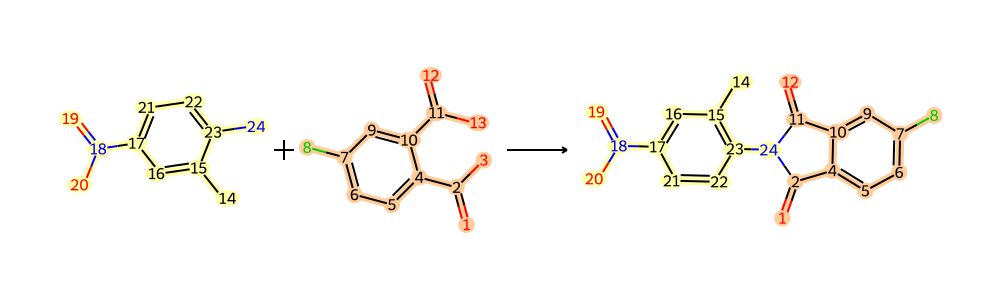

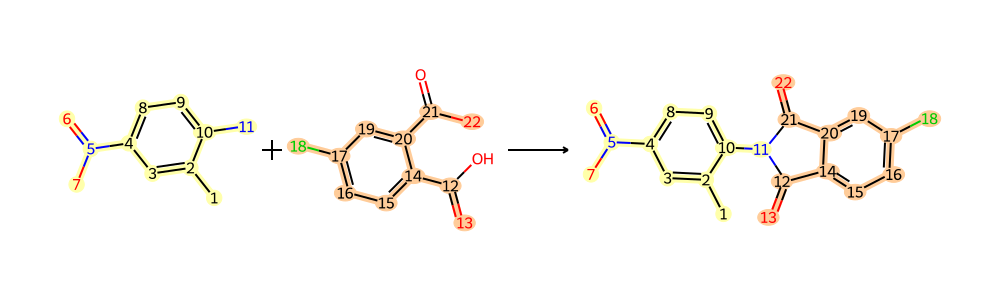

In [27]:
i= 3
display(vis.visualize_reaction(check[i]['ground_truth'], img_size=(1000, 300), show_atom_map=True))
display(vis.visualize_reaction(check[i]['rxn_mapper'], img_size=(1000, 300), show_atom_map=True))

# **2. Human check**

In [8]:
import pandas as pd
uspto = pd.read_csv('../../Data/AAM/aam_benchmark/USPTO_sampled.csv')
uspto['Ground Truth'] = uspto['LocalMapper'] ## Assume LocalMapper is the ground truth as reported in the paper

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator
uspto_results, _ = AMMValidator.validate_smiles(
        data=uspto,
        ground_truth_col="Ground Truth",
        mapped_cols=["RXNMapper", "GraphMapper", "LocalMapper"],
        check_method="RC",
        ignore_aromaticity=False,
        n_jobs=1,
        verbose=0,
        ensemble=False,
        ignore_tautomers=False
    )
uspto_results = pd.DataFrame(uspto_results)

In [11]:
uspto_results

,mapper,accuracy,results,success_rate
0,RXNMapper,0.935333,"[True, True, True, True, True, True, True, Tru...",100
1,GraphMapper,0.951000,"[True, True, True, True, True, True, True, Tru...",100
2,LocalMapper,1.000000,"[True, True, True, True, True, True, True, Tru...",100


In [13]:
print('RXNMapper accuracy:', uspto['RXNMapper_correct'].sum()/3000)
print('GraphMapper accuracy:', uspto['GraphMapper_correct'].sum()/3000)


RXNMapper accuracy: 0.9353333333333333
GraphMapper accuracy: 0.951


In [15]:
list_diff_rxn= []
for key, value in enumerate(uspto['RXNMapper_correct']):
    if value != uspto_results['results'][0][key]:
        list_diff_rxn.append(key)

list_diff_graph= []
for key, value in enumerate(uspto['GraphMapper_correct']):
    if value != uspto_results['results'][1][key]:
        list_diff_graph.append(key)
print('Differences in RXNMapper:', list_diff_rxn)
print('Differences in GraphMapper:', list_diff_graph)
        

Differences in RXNMapper: [192, 2157]
Differences in GraphMapper: []


In [20]:
uspto.iloc[list_diff_rxn,:]

,sampled_id,RXNMapper,GraphMapper,LocalMapper,RXNMapper_correct,GraphMapper_correct,LocalMapper_correct,Ground Truth
192,31737,[CH3:1][CH2:2][OH:3].CC[O-].F[c:4]1[c:5]([Cl:6...,[CH2:2]([CH3:1])[OH:3].[H-:17].[Na+:18].[Na+:1...,CCO.F[c:4]1[c:5]([Cl:6])[cH:7][n:8][c:9]([F:10...,True,True,True,CCO.F[c:4]1[c:5]([Cl:6])[cH:7][n:8][c:9]([F:10...
2157,12189,Br[C:4]([CH:2]([CH3:1])[Br:3])=[O:5].CCN(CC)CC...,[CH2:8]([CH3:7])[N:9]([CH2:10][CH3:11])[CH2:12...,Br[C:1]([CH:2]([CH3:3])[Br:4])=[O:5].CCN(CC)CC...,False,False,True,Br[C:1]([CH:2]([CH3:3])[Br:4])=[O:5].CCN(CC)CC...


In [16]:
uspto.loc[192,'LocalMapper']

'CCO.F[c:4]1[c:5]([Cl:6])[cH:7][n:8][c:9]([F:10])[c:11]1[Cl:12].[CH3:1][CH2:2][O-:3].[H-].[Na+].[Na+]>>[CH3:1][CH2:2][O:3][c:4]1[c:5]([Cl:6])[cH:7][n:8][c:9]([F:10])[c:11]1[Cl:12]'

[16:08:58] reactant 0 has no mapped atoms.
[16:08:58] reactant 3 has no mapped atoms.
[16:08:58] reactant 4 has no mapped atoms.
[16:08:58] reactant 5 has no mapped atoms.
[16:08:58] reactant 0 has no mapped atoms.
[16:08:58] reactant 3 has no mapped atoms.
[16:08:58] reactant 4 has no mapped atoms.
[16:08:58] reactant 5 has no mapped atoms.
[16:08:58] reactant 0 has no mapped atoms.
[16:08:58] reactant 3 has no mapped atoms.
[16:08:58] reactant 4 has no mapped atoms.
[16:08:58] reactant 5 has no mapped atoms.


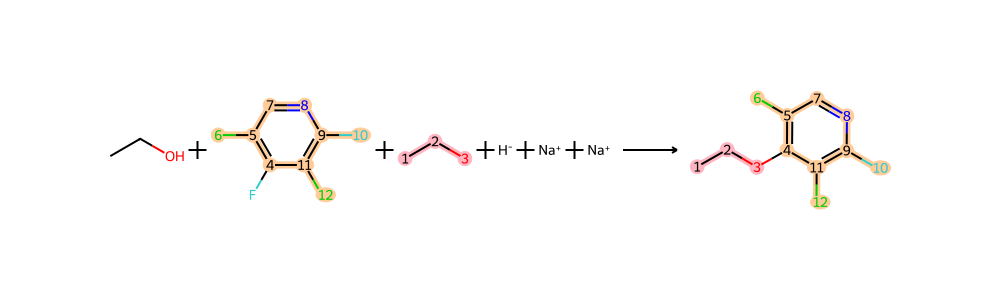

[16:08:58] reactant 1 has no mapped atoms.
[16:08:58] reactant 3 has no mapped atoms.
[16:08:58] reactant 4 has no mapped atoms.
[16:08:58] reactant 5 has no mapped atoms.
[16:08:58] reactant 1 has no mapped atoms.
[16:08:58] reactant 3 has no mapped atoms.
[16:08:58] reactant 4 has no mapped atoms.
[16:08:58] reactant 5 has no mapped atoms.
[16:08:58] reactant 1 has no mapped atoms.
[16:08:58] reactant 3 has no mapped atoms.
[16:08:58] reactant 4 has no mapped atoms.
[16:08:58] reactant 5 has no mapped atoms.


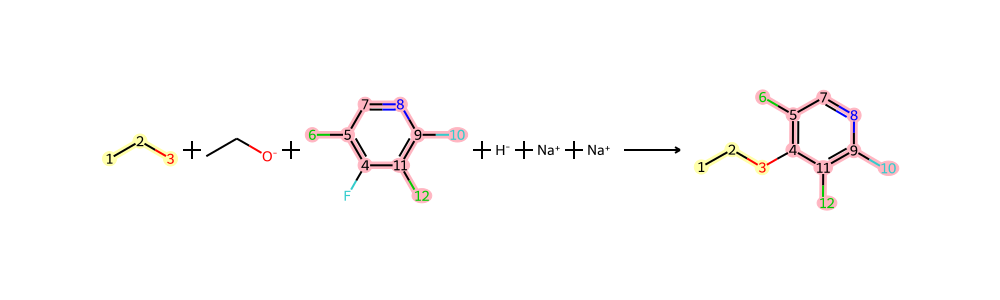

In [17]:
from SynTemp.SynVis.chemical_reaction_visualizer import ChemicalReactionVisualizer

vis = ChemicalReactionVisualizer()
i = 192
display(vis.visualize_reaction(uspto.loc[i,'LocalMapper'], img_size=(1000, 300), show_atom_map=True))
display(vis.visualize_reaction(uspto.loc[i,'RXNMapper'], img_size=(1000, 300), show_atom_map=True))

[16:09:16] reactant 1 has no mapped atoms.
[16:09:16] reactant 2 has no mapped atoms.
[16:09:16] reactant 1 has no mapped atoms.
[16:09:16] reactant 2 has no mapped atoms.
[16:09:16] reactant 1 has no mapped atoms.
[16:09:16] reactant 2 has no mapped atoms.


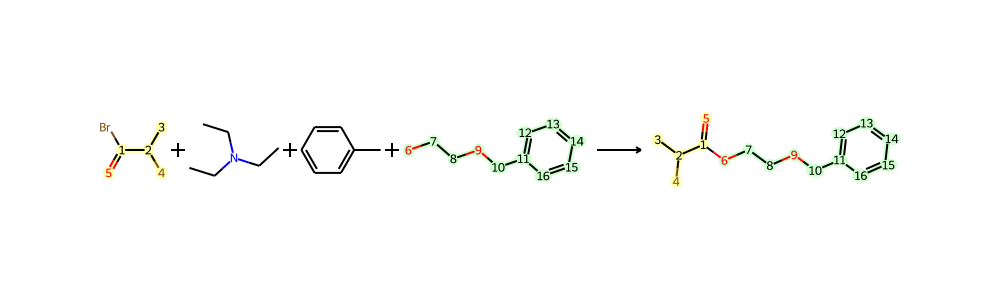

[16:09:16] reactant 1 has no mapped atoms.
[16:09:16] reactant 2 has no mapped atoms.
[16:09:16] reactant 1 has no mapped atoms.
[16:09:16] reactant 2 has no mapped atoms.
[16:09:16] reactant 1 has no mapped atoms.
[16:09:16] reactant 2 has no mapped atoms.


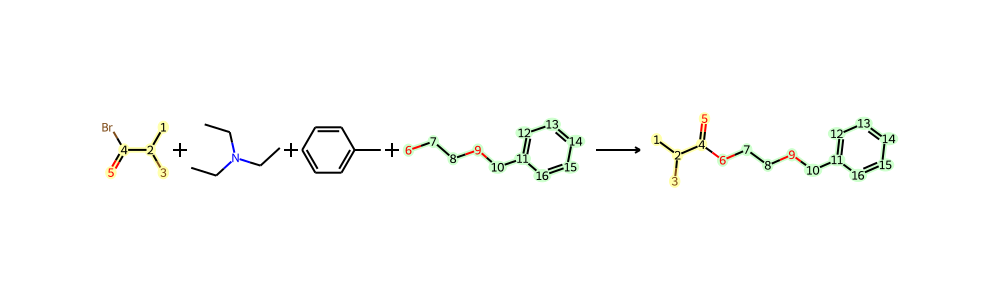

In [19]:
i = 2157
display(vis.visualize_reaction(uspto.loc[i,'LocalMapper'], img_size=(1000, 300), show_atom_map=True))
display(vis.visualize_reaction(uspto.loc[i,'RXNMapper'], img_size=(1000, 300), show_atom_map=True))